In [22]:
import pandas as pd
import os
import glob
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
pd.options.mode.chained_assignment = None
from scipy import stats
from tqdm import tqdm
sns.set_theme()
sns.set(font_scale=1)

EPSILON = 0.001
PHYS_PROPERTY = {'equate_1':'AD-controlled', 'equate_2': 'TS-controlled', 'equate_3': 'CH-controlled'}
PHYS_PROPERTY_TO_NUM = {'Average Diameter':1, 'Total Surface Area':2, 'Convex Hull': 3}
NUM_TO_PHYS_PROPERTY = {1: 'AD-controlled', 2: 'TS-controlled', 3: 'CH-controlled'}
EXPERIMENTS = ['size', 'count', 'size-count', 'count-size', 'colors', 'colors-count']
CONGRUENT_COLUMNS = ['Ratio 50 Congruent Validation Accuracy',
                     'Ratio 56 Congruent Validation Accuracy',
                     'Ratio 63 Congruent Validation Accuracy',
                     'Ratio 71 Congruent Validation Accuracy',
                     'Ratio 75 Congruent Validation Accuracy',
                     'Ratio 86 Congruent Validation Accuracy']
INCONGRUENT_COLUMNS = ['Ratio 50 Incongruent Validation Accuracy',
                     'Ratio 56 Incongruent Validation Accuracy',
                     'Ratio 63 Incongruent Validation Accuracy',
                     'Ratio 71 Incongruent Validation Accuracy',
                     'Ratio 75 Incongruent Validation Accuracy',
                     'Ratio 86 Incongruent Validation Accuracy']
TO_REMOVE = 9999999.9
STD_FILTER = 2.5
CONGRUENT_VALUE = 1
INCONGRUENT_VALUE = 0
CONGRUENCY = {CONGRUENT_VALUE: "Congruent", INCONGRUENT_VALUE: "Incongruent"}
RATIOS = ['50','56','63','71','75','86']

In [2]:
# def plot_multiple_traces(fig, data, x, y, y2, y3, y4, row, col, subtitle_index, subtitle):
#     fig.add_trace(
#         go.Scatter(x=data[x], y=data[y], name=y),
#         row=row, col=col,
#         secondary_y=False,
#     )
#     fig.add_trace(
#         go.Scatter(x=data[x], y=data[y2], name=y2),
#         row=row, col=col,
#         secondary_y=True,
#     )
#
#     fig.add_trace(
#         go.Scatter(x=data[x], y=data[y3], name=y3),
#         row=row, col=col,
#         secondary_y=False,
#     )
#
#     fig.add_trace(
#         go.Scatter(x=data[x], y=data[y4], name=y4),
#         row=row, col=col,
#         secondary_y=True,
#     )
#
#     fig.layout.annotations[subtitle_index].update(text=subtitle)

In [3]:
# def plot_graph(data, title, x, y, y2, color=None, is_line_plot=True):
#     if color:
#         fig = make_subplots(specs=[[{"secondary_y": True}]])
#         if is_line_plot:
#             fig.add_trace(
#             go.Scatter(x=data[x], y=data[y], name=y),
#             secondary_y=False,
#         )
#             if y2:
#                 fig.add_trace(
#                     go.Scatter(x=data[x], y=data[y2], name=y2),
#                     secondary_y=True,
#                 )
#         else:
#             fig = px.histogram(data, x=x, y=y, color=color,  barmode='group', text_auto=True, color_discrete_sequence = px.colors.qualitative.Safe)
#     else:
#         if is_line_plot:
#             fig = px.line(data, x=x, y=y)
#         else:
#             fig = px.histogram(data, x=x, y=y, color=color,  barmode='group', text_auto=True, color_discrete_sequence = px.colors.qualitative.Safe)
#     fig.update_layout(
#         title=title,
#         xaxis_title=x,
#         yaxis_title=y,)
#         # coloraxis={'colorscale': 'Viridis'})
#     fig.show()

In [12]:
def split_train_test_results(files_names):
    tests = []
    for file in files_names:
        if "Tested_on" in file:
            tests.append(file)
        else:
            train = file
    return tests, train

Train and test result files as a dict

In [13]:
#'Ratio 86 Incongruent Training Accuracy' should be replaced with 'Ratio 86 Congruent Training Loss'
#'Ratio 86 Incongruent Validation Accuracy' should be replaced with 'Ratio 86 Congruent Validation Loss'
def fix_columns(df_to_fix_column_titles, should_fix_titles=True):
    if not should_fix_titles:
        return
    df_to_fix_column_titles.rename(columns={'Ratio 86 Congruent Training Loss': 'loss_temp'}, inplace=True)
    df_to_fix_column_titles.rename(columns={'Ratio 86 Incongruent Training Accuracy': 'Ratio 86 Congruent Training Loss'}, inplace=True)
    df_to_fix_column_titles.rename(columns={'loss_temp': 'Ratio 86 Incongruent Training Accuracy'}, inplace=True)

    df_to_fix_column_titles.rename(columns={'Ratio 86 Congruent Validation Loss': 'loss_temp'}, inplace=True)
    df_to_fix_column_titles.rename(columns={'Ratio 86 Incongruent Validation Accuracy': 'Ratio 86 Congruent Validation Loss'}, inplace=True)
    df_to_fix_column_titles.rename(columns={'loss_temp': 'Ratio 86 Incongruent Validation Accuracy'}, inplace=True)

Aggregate all files into dict

In [23]:
PATH = "/Users/gali.k/phd/phd_2021/results"
result_dict = {}
for equate in PHYS_PROPERTY.keys():
    equate_dict = {}
    for experiment in EXPERIMENTS:
        curr_results_path = PATH + os.sep + equate + os.sep + experiment
        result_file_names = glob.glob(curr_results_path + os.sep + f"Results_*.csv")
        if len(result_file_names) > 0:
            tests, training_result_file_name = split_train_test_results(result_file_names)
            testing_file_name1 = tests[0]
            testing_file_name2 = tests[1]
            training_result_df = pd.read_csv(training_result_file_name)
            fix_columns(training_result_df)
            testing_file_1_df =  pd.read_csv(testing_file_name1)
            fix_columns(testing_file_1_df)
            testing_file_1_df['Tested_On_Equate'] = testing_file_name1[testing_file_name1.find('Tested_on'): testing_file_name1.find('AvgAccuracy')-1].replace('Tested_on_Equate', 'equate')
            testing_file_2_df =  pd.read_csv(testing_file_name2)
            fix_columns(testing_file_2_df)
            testing_file_2_df['Tested_On_Equate'] = testing_file_name2[testing_file_name2.find('Tested_on'): testing_file_name2.find('AvgAccuracy')-1].replace('Tested_on_Equate', 'equate')

            equate_dict.update({experiment: { "train" : training_result_df,
                                "test_1": testing_file_1_df,
                                "test_2": testing_file_2_df}})
            result_dict.update({equate: equate_dict})

In [130]:
# def add_congruency(df):
#     column_names = list(df.columns)
#     new_df = pd.DataFrame()
#     for col in column_names:
#         curr_df = pd.DataFrame()
#         if "Incongruent" in col:
#             curr_df[col.replace('Incongruent', '')] = df[col]
#             curr_df["Congruency"] = 0
#         elif "Congruent" in col:
#             curr_df[col.replace('Congruent', '')] = df[col]
#             curr_df["Congruency"] = 1
#         else:
#            curr_df[col] = df[col]
#         new_df = pd.concat([new_df, curr_df])
#     return new_df

Analysis #1: Trained on stimuli X and tested on Y

In [9]:
# def process_df(agg_df, curr_df, trained_on, tested_on, task):
#     last_gen = curr_df['Generations'].max()
#
#     columns_to_keep = CONGRUENT_COLUMNS.copy()
#     columns_to_keep.append('Subject_UID')
#     cong_df = curr_df.query(f"Generations == {last_gen}")[columns_to_keep]
#     cong_df['Congruency'] = CONGRUENT_VALUE
#
#     columns_to_keep = INCONGRUENT_COLUMNS.copy()
#     columns_to_keep.append('Subject_UID')
#     incong_df = curr_df.query(f"Generations == {last_gen}")[columns_to_keep]
#     incong_df['Congruency'] = INCONGRUENT_VALUE
#
#     validation_acc_cong = pd.DataFrame()
#
#     validation_acc_cong['Validation Accuracy'] = [cong_df[CONGRUENT_COLUMNS].mean().reset_index()[0].mean()]
#     validation_acc_cong['Congruency'] = [CONGRUENT_VALUE]
#     validation_acc_cong['Train'] = [trained_on]
#     validation_acc_cong['Test'] = [tested_on]
#     validation_acc_cong['Train & Test'] = ['train: ' + trained_on + '<br>' + 'test: ' + tested_on]
#     validation_acc_cong['Task'] = [task]
#     validation_acc_incong = pd.DataFrame()
#     validation_acc_incong['Validation Accuracy'] = [incong_df[INCONGRUENT_COLUMNS].mean().reset_index()[0].mean()]
#     validation_acc_incong['Congruency'] = [INCONGRUENT_VALUE]
#     validation_acc_incong['Train'] = [trained_on]
#     validation_acc_incong['Test'] = [tested_on]
#     validation_acc_incong['Train & Test'] = ['train: ' + trained_on + '<br>' + 'test: ' + tested_on]
#     validation_acc_incong['Task'] = [task]
#     agg_df = pd.concat([agg_df, validation_acc_cong])
#     agg_df = pd.concat([agg_df, validation_acc_incong])
#     return agg_df

In [8]:
# def drop_na_and_extreme_values1(df, columns_list, th):
#     print(f'length before preprocess {len(df)}')
#
#     df_with_nans_total = pd.DataFrame()
#     df_with_extreme_total = pd.DataFrame()
#     for col in columns_list:
#         df_with_nans = pd.DataFrame()
#         df_with_nans[col] = df[df[col].isna()]
#         df_with_nans_total = pd.concat([df_with_nans_total, df_with_nans])
#         df_without_nulls = pd.DataFrame()
#         df_without_nulls[col] = df[~df[col].isna()]
#         abs_z_scores = np.abs(stats.zscore(df_without_nulls[col]))
#         df_with_extreme = pd.DataFrame()
#         df_with_extreme[col] = df[col][(abs_z_scores > STD_FILTER)]
#         df_with_extreme_total = pd.concat([df_with_extreme_total, df_with_extreme])
#         print(f'removing {len(df_with_extreme)} rows with extreme values')
#
#     df_with_nans_total.to_csv("df_with_nans_total.csv")
#     df_with_extreme_total.to_csv("df_with_extreme_total.csv")
#
#     filtered_df = df[~df_with_extreme_total]
#
#     print(f'length after preprocess {len(filtered_df)}')
#     pass
#     df = filtered_df

In [133]:
# def calc_z_score_and_replace_with_mean(df, columns_list):
#     for col in columns_list:
#         # filter nans in order to calc zscore
#         df_without_nans = df[~df[col].isna()]
#
#         # replace nan datapoints with mean:
#         abs_z_scores = np.abs(stats.zscore(df_without_nans[col]))
#         mean_val = df_without_nans[col][(abs_z_scores <= STD_FILTER)].mean()
#         df[col] = df[col].fillna(mean_val)
#
#         #calc z score again:
#         abs_z_scores = np.abs(stats.zscore(df[col]))
#         #replace extreme values with p90
#         p90_val = df[col][(abs_z_scores <= STD_FILTER)].quantile(.90)
#
#         if (df[col][(abs_z_scores > STD_FILTER)] is not None) and (not df[col][(abs_z_scores > STD_FILTER)].empty):
#             extreme_datapoints = df[col][(abs_z_scores > STD_FILTER)].values[0]
#             #print(f'column {col}: replaced {extreme_datapoints} with {mean_val}')
#             df[col].replace(extreme_datapoints, p90_val, inplace = True)

In [134]:
# def normalize_extreme_values(df):
#     normal_df = pd.DataFrame()
#     gens = list(df['Generations'].unique())
#     for gen in gens:
#         cur_gen_df = df.query(f"Generations == {gen}").copy()
#         acc_columns = list(cur_gen_df.filter(regex='.*Accuracy').columns)
#         loss_columns = list(cur_gen_df.filter(regex='.*Loss').columns)
#         print('Preprocess Accutacy')
#         drop_na_and_extreme_values1(cur_gen_df, acc_columns, th=1)
#         print('Preprocess Loss')
#         drop_na_and_extreme_values1(cur_gen_df, loss_columns, th=100)
#         # calc_z_score_and_replace_with_mean(cur_gen_df, acc_columns)
#         # calc_z_score_and_replace_with_mean(cur_gen_df, loss_columns)
#         normal_df = pd.concat([normal_df, cur_gen_df])
#     return normal_df

Preprocess the dataframe

In [32]:
# def process_for_graphs():
#     final_df = pd.DataFrame()
#     for phys_prop in result_dict.keys():
#         print(f"Working on {phys_prop}")
#         exp_result = result_dict[phys_prop]
#         for exp in exp_result.keys():
#             train_df = exp_result[exp]['train']
#             train_df_new = normalize_extreme_values(train_df)
#             final_df = process_df(final_df, train_df_new, PHYS_PROPERTY[phys_prop], PHYS_PROPERTY[phys_prop], exp)
#
#             test1_df = exp_result[exp]['test_1']
#             test1_df_new = normalize_extreme_values(test1_df)
#             final_df = process_df(final_df, test1_df_new, PHYS_PROPERTY[phys_prop], PHYS_PROPERTY[test1_df['Tested_On_Equate'][0]], exp)
#
#             test2_df = exp_result[exp]['test_2']
#             test2_df_new = normalize_extreme_values(test2_df)
#             final_df = process_df(final_df, test2_df_new, PHYS_PROPERTY[phys_prop], PHYS_PROPERTY[test2_df['Tested_On_Equate'][0]], exp)
#     return final_df

Heatmaps for different physical properties

In [33]:
# def heatmaps(final_df):
#     tasks = list(final_df['Task'].unique())
#     congruency_vals = [0, 1]
#     for task in tasks:
#         for cong_val in congruency_vals:
#             task_df = final_df.query(f"Task == '{task}' & Congruency == {cong_val}")
#             task_df = task_df[['Train', 'Test', 'Validation Accuracy']]
#             df_for_heatmap = pd.pivot_table(task_df, values='Validation Accuracy', index='Train', columns='Test')
#             f, ax = plt.subplots(figsize=(9, 6))
#             df_for_heatmap = df_for_heatmap.round(decimals=4)
#             sns.heatmap(df_for_heatmap, annot=True, linewidths=.5, ax=ax).set(title=f"Train VS Test [Task = {task}, isCongruent = {CONGRUENCY[cong_val]}]")

In [34]:
# def graphs(final_df):
#     tasks = list(final_df['Task'].unique())
#     for task in tasks:
#         plot_graph(final_df.query(f"Task == '{task}'"), f'Task = {task}: Tests results when training on stimuli with different physical properties', 'Train & Test', 'Validation Accuracy',
#         None, color='Congruency', is_line_plot=False)

Create ANOVA CSV

In [24]:
def prepare_ratios_df(curr_df):
    ratios_df = pd.DataFrame()
    for ratio in RATIOS:
        ratio_cong_df = pd.DataFrame()
        ratio_cong_df['UNIQUE_SUBJECT_UID'] = curr_df['UNIQUE_SUBJECT_UID']
        ratio_cong_df['Task'] = curr_df['Task']
        ratio_cong_df['Generations'] = curr_df['Generations']
        ratio_cong_df['Train'] = curr_df['Equate'].apply(lambda val: NUM_TO_PHYS_PROPERTY[val])
        ratio_cong_df['Test'] = curr_df['Tested_On_Equate'].apply(lambda val: PHYS_PROPERTY[val])
        ratio_cong_df['Congruity'] = 'Congruent'
        ratio_cong_df['Ratio'] = ratio
        ratio_cong_df['Training Accuracy'] = curr_df[f'Ratio {ratio} Congruent Training Accuracy']
        ratio_cong_df['Validation Accuracy'] = curr_df[f'Ratio {ratio} Congruent Validation Accuracy']
        ratio_cong_df['Training Loss'] = curr_df[f'Ratio {ratio} Congruent Validation Loss']
        ratio_cong_df['Validation Loss'] = curr_df[f'Ratio {ratio} Congruent Validation Loss']
        ratio_cong_df['Layers'] = curr_df['Layers']
        ratio_cong_df['Neurons'] = curr_df['Nuerons']
        ratio_cong_df['Activation'] = curr_df['Activation']
        ratio_cong_df['Optimizer'] = curr_df['Optimizer']

        ratio_incong_df = pd.DataFrame()
        ratio_incong_df['UNIQUE_SUBJECT_UID'] = curr_df['UNIQUE_SUBJECT_UID']
        ratio_incong_df['Task'] = curr_df['Task']
        ratio_incong_df['Generations'] = curr_df['Generations']
        ratio_incong_df['Train'] = curr_df['Equate'].apply(lambda val: NUM_TO_PHYS_PROPERTY[val])
        ratio_incong_df['Test'] = curr_df['Tested_On_Equate'].apply(lambda val: PHYS_PROPERTY[val])
        ratio_incong_df['Congruity'] = 'Incongruent'
        ratio_incong_df['Ratio'] = ratio
        ratio_incong_df['Training Accuracy'] = curr_df[f'Ratio {ratio} Incongruent Training Accuracy']
        ratio_incong_df['Validation Accuracy'] = curr_df[f'Ratio {ratio} Incongruent Validation Accuracy']
        ratio_incong_df['Training Loss'] = curr_df[f'Ratio {ratio} Incongruent Validation Loss']
        ratio_incong_df['Validation Loss'] = curr_df[f'Ratio {ratio} Incongruent Validation Loss']
        ratio_incong_df['Layers'] = curr_df['Layers']
        ratio_incong_df['Neurons'] = curr_df['Nuerons']
        ratio_incong_df['Activation'] = curr_df['Activation']
        ratio_incong_df['Optimizer'] = curr_df['Optimizer']

        ratio_df = pd.concat([ratio_cong_df, ratio_incong_df])
        ratios_df = pd.concat([ratios_df, ratio_df])
    return ratios_df.reset_index(drop=True)

In [25]:
result_dict.keys()
anova_df = pd.DataFrame()
mixed_anova_df = pd.DataFrame()
for phys_prop in tqdm(result_dict.keys()):
    #print(f"Working on {phys_prop}")
    exp_result = result_dict[phys_prop]
    for task in exp_result.keys():
        #print(f"Task: {task}")
        train_df = exp_result[task]['train']
        last_gen = train_df['Generations'].max()
        train_df = train_df.query(f"Generations == {last_gen}")
        train_df['Tested_On_Equate'] = phys_prop
        train_df['UNIQUE_SUBJECT_UID'] = train_df['Subject_UID'].apply(lambda x: task + "_" + phys_prop + "_" + str(x))
        train_ratios_df = prepare_ratios_df(train_df)

        test1_df = exp_result[task]['test_1']
        test1_df['UNIQUE_SUBJECT_UID'] = test1_df['Subject_UID'].apply(lambda x: task + "_" + phys_prop + "_" + str(x))
        test_1_ratios_df = prepare_ratios_df(test1_df)

        test2_df = exp_result[task]['test_2']
        test2_df['UNIQUE_SUBJECT_UID'] = test2_df['Subject_UID'].apply(lambda x: task + "_" + phys_prop + "_" + str(x))
        test_2_ratios_df = prepare_ratios_df(test2_df)

        mixed_anova_df = pd.concat([mixed_anova_df, train_ratios_df])
        mixed_anova_df = pd.concat([mixed_anova_df, test_1_ratios_df])
        mixed_anova_df = pd.concat([mixed_anova_df, test_2_ratios_df])
mixed_anova_df.to_csv('mixed_anova_df.csv')

100%|██████████| 3/3 [00:03<00:00,  1.23s/it]


In [26]:
len(mixed_anova_df)

12960

Filter nulls

In [27]:
non_na_mixed_anova = mixed_anova_df.dropna()
len(non_na_mixed_anova)

12852

In [ ]:
non_na_mixed_anova.describe()

In [139]:
non_na_mixed_anova.columns

Index(['UNIQUE_SUBJECT_UID', 'Task', 'Train', 'Test', 'Congruency', 'Ratio',
       'Training Accuracy', 'Validation Accuracy', 'Training Loss',
       'Validation Loss', 'Layers', 'Nuerons', 'Activation', 'Optimizer'],
      dtype='object')

Filter extreme values

In [30]:
anova_df_for_R = non_na_mixed_anova[['UNIQUE_SUBJECT_UID', 'Task','Train','Test','Generations','Congruity','Ratio','Validation Accuracy']]
anova_df_for_R.head()

,UNIQUE_SUBJECT_UID,Task,Train,Test,Generations,Congruity,Ratio,Validation Accuracy
0,size_equate_1_161,size,AD-controlled,AD-controlled,9,Congruent,50,1.0
1,size_equate_1_162,size,AD-controlled,AD-controlled,9,Congruent,50,1.0
2,size_equate_1_163,size,AD-controlled,AD-controlled,9,Congruent,50,1.0
3,size_equate_1_164,size,AD-controlled,AD-controlled,9,Congruent,50,1.0
4,size_equate_1_165,size,AD-controlled,AD-controlled,9,Congruent,50,1.0


In [31]:
anova_df_for_R.to_csv("anova_df_for_R_30_12_22.csv")

Total Generations data

In [53]:
anova_df_for_R_total_generations = anova_df_for_R[['UNIQUE_SUBJECT_UID', 'Task','Train', 'Generations']].groupby(['UNIQUE_SUBJECT_UID', 'Task','Train']).mean()

In [54]:
anova_df_for_R_total_generations.to_csv("anova_df_for_R_31_12_22_generations.csv")

Separating to physical and numerical

In [33]:
anova_df_for_R_physical_runs = anova_df_for_R.query(f"Task == 'size' or Task == 'count-size' or Task == 'colors'")

In [35]:
anova_df_for_R_numerical_runs = anova_df_for_R.query(f"Task == 'count' or Task == 'size-count' or Task == 'colors-count'")

In [36]:
anova_df_for_R_physical_runs.to_csv("anova_df_for_R_30_12_22_physical_accuracy.csv")

In [37]:
anova_df_for_R_numerical_runs.to_csv("anova_df_for_R_30_12_22_numerical_accuracy.csv")

In [41]:
anova_df_for_R_numerical_runs_generations = anova_df_for_R_numerical_runs[['UNIQUE_SUBJECT_UID', 'Task','Train', 'Generations']].groupby(['UNIQUE_SUBJECT_UID', 'Task','Train']).mean()

In [43]:
anova_df_for_R_numerical_runs_generations['Generations'].unique()

array([ 6., 19.,  3.,  9., 10., 30.])

In [44]:
anova_df_for_R_numerical_runs_generations.to_csv("anova_df_for_R_30_12_22_numerical_generations.csv")

In [45]:
anova_df_for_R_physical_runs_generations = anova_df_for_R_physical_runs[['UNIQUE_SUBJECT_UID', 'Task','Train', 'Generations']].groupby(['UNIQUE_SUBJECT_UID', 'Task','Train']).mean()

In [46]:
anova_df_for_R_physical_runs_generations.to_csv("anova_df_for_R_30_12_22_physical_generations.csv")

************* Until here for the R anova analysis! **************

In [55]:
overall_means_physical = anova_df_for_R_physical_runs[['Task','Congruity', 'Validation Accuracy']].groupby(['Task','Congruity']).mean()

In [56]:
overall_means_physical.head(10)

Validation Accuracy
Task       Congruity                       
colors     Congruent               0.967098
           Incongruent             0.967385
count-size Congruent               0.923611
           Incongruent             0.849537
size       Congruent               0.888056
           Incongruent             0.835370

In [47]:
generations_df = pd.read_csv("/Users/gali.k/phd/phd_2021/data_analysis/analysis/generations_exp_1.csv")

In [49]:
generations_df.drop(columns="Unnamed: 0", inplace=True)

In [52]:
generations_df.head(10)

,Task,Train,Generations
0,colors-count,AD-controlled,6
1,colors-count,CH-controlled,3
2,colors-count,TS-controlled,19
3,count,AD-controlled,9
4,count,CH-controlled,3
5,count,TS-controlled,10
6,size-count,AD-controlled,6
7,size-count,CH-controlled,6
8,size-count,TS-controlled,30


In [51]:
from scipy.stats import chi2_contingency
stat, p, dof, expected = chi2_contingency(generations_df)

TypeError: '<' not supported between instances of 'str' and 'int'

In [ ]:
non_na_mixed_anova['abs_z_scores'] = np.abs(stats.zscore(non_na_mixed_anova['Validation Accuracy']))
non_na_mixed_anova.head(100)

In [14]:
mixed_anova_normalized = pd.DataFrame()
mixed_anova_normalized = non_na_mixed_anova.query(f'abs_z_scores <= {STD_FILTER}')
len(mixed_anova_normalized)

12804

In [15]:
non_na_mixed_anova.to_csv("non_na_mixed_anova.csv")

5-WAY MIXED ANOVA

In [60]:
anova_df = pd.read_csv("anova_df_for_R.csv")
anova_df.drop(columns=['Unnamed: 0'], inplace=True)
anova_df.head()

,UNIQUE_SUBJECT_UID,Task,Train,Test,Congruency,Ratio,Validation Accuracy
0,size_equate_1_501,size,Average Diameter,Average Diameter,1,50,1.0
1,size_equate_1_502,size,Average Diameter,Average Diameter,1,50,1.0
2,size_equate_1_503,size,Average Diameter,Average Diameter,1,50,1.0
3,size_equate_1_504,size,Average Diameter,Average Diameter,1,50,1.0
4,size_equate_1_505,size,Average Diameter,Average Diameter,1,50,1.0


In [113]:
anova_df_for_plots = mixed_anova_df.copy()
anova_df_for_plots['Task_Train'] = anova_df_for_plots[['Task','Train']].apply(lambda row: row.Task +"_"+ row.Train, axis=1)
anova_df_for_plots['Task_Test'] = anova_df_for_plots[['Task','Test']].apply(lambda row: row.Task +"_"+ row.Test, axis=1)
# anova_df_for_plots['Task_Test'] = anova_df_for_plots.apply(lambda row: row['Task'] + "_"+ row['Test'])
anova_df_for_plots.head()

,UNIQUE_SUBJECT_UID,Task,Train,Test,Congruency,Ratio,Training Accuracy,Validation Accuracy,Training Loss,Validation Loss,Layers,Nuerons,Activation,Optimizer,Task_Train,Task_Test
0,size_equate_1_501,size,Average Diameter,Average Diameter,1,50,1.0,1.0,0.1669,0.1669,2,"[128, 32, 32]",linear,adam,size_Average Diameter,size_Average Diameter
1,size_equate_1_502,size,Average Diameter,Average Diameter,1,50,1.0,1.0,0.3000,0.3000,3,"[64, 64, 32]",tanh,adamax,size_Average Diameter,size_Average Diameter
2,size_equate_1_503,size,Average Diameter,Average Diameter,1,50,1.0,1.0,0.1808,0.1808,4,"[32, 16, 64]",elu,rmsprop,size_Average Diameter,size_Average Diameter
3,size_equate_1_504,size,Average Diameter,Average Diameter,1,50,1.0,1.0,0.1326,0.1326,2,"[16, 16, 128]",linear,adagrad,size_Average Diameter,size_Average Diameter
4,size_equate_1_505,size,Average Diameter,Average Diameter,1,50,1.0,1.0,0.0523,0.0523,2,"[16, 64, 128]",linear,adam,size_Average Diameter,size_Average Diameter


In [87]:
anova_df_for_plots.describe()
import scipy.stats as sp
sp.describe(anova_df_for_plots['Validation Accuracy'])

DescribeResult(nobs=12960, minmax=(0.0, 1.0), mean=0.7946566358024691, variance=0.10645863662545883, skewness=-1.4300883589665974, kurtosis=0.5946646923582786)

In [114]:
anova_df_for_plots_grouped = anova_df_for_plots.query(f"Task == 'count' or Task =='size-count' or Task == 'colors-count'").groupby(['Task_Train', 'Task_Test', 'Task', 'Congruency']).mean()
anova_df_for_plots_grouped.reset_index(inplace=True)
anova_df_for_plots_grouped.head()

/var/folders/bw/951w4nh12991sq82d74c_gv9gj4m7h/T/ipykernel_3907/1791719876.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



,Task_Train,Task_Test,Task,Congruency,Training Accuracy,Validation Accuracy,Training Loss,Validation Loss,Layers
0,colors-count_Average Diameter,colors-count_Average Diameter,colors-count,0,0.833333,0.833333,0.647341,0.647341,3.15
1,colors-count_Average Diameter,colors-count_Average Diameter,colors-count,1,0.825000,0.825000,0.639725,0.639725,3.15
2,colors-count_Average Diameter,colors-count_Convex Hull,colors-count,0,0.808333,0.808333,0.715973,0.715973,3.15
3,colors-count_Average Diameter,colors-count_Convex Hull,colors-count,1,0.800000,0.800000,0.728782,0.728782,3.15
4,colors-count_Average Diameter,colors-count_Total Surface Area,colors-count,0,0.383333,0.383333,1.898769,1.898769,3.15


In [115]:
anova_df_for_plots_grouped.columns

Index(['Task_Train', 'Task_Test', 'Task', 'Congruency', 'Training Accuracy',
       'Validation Accuracy', 'Training Loss', 'Validation Loss', 'Layers'],
      dtype='object')

In [128]:
anova_df_for_plots_grouped.head()

,Task_Train,Task_Test,Task,Congruency,Training Accuracy,Validation Accuracy,Training Loss,Validation Loss,Layers
0,colors-count_Average Diameter,colors-count_Average Diameter,colors-count,0,0.833333,0.833333,0.647341,0.647341,3.15
1,colors-count_Average Diameter,colors-count_Average Diameter,colors-count,1,0.825000,0.825000,0.639725,0.639725,3.15
2,colors-count_Average Diameter,colors-count_Convex Hull,colors-count,0,0.808333,0.808333,0.715973,0.715973,3.15
3,colors-count_Average Diameter,colors-count_Convex Hull,colors-count,1,0.800000,0.800000,0.728782,0.728782,3.15
4,colors-count_Average Diameter,colors-count_Total Surface Area,colors-count,0,0.383333,0.383333,1.898769,1.898769,3.15


In [116]:
fig = px.bar(anova_df_for_plots_grouped.query(f"(Task == 'count' or Task =='size-count' or Task == 'colors-count') and (Congruency == 0)"), x='Task_Test', y='Validation Accuracy', color='Task_Train', barmode='group')

fig.update_layout(
    title='Accuracy Incongruent',
    xaxis_title='Test',
    yaxis_title='Accuacy',
    coloraxis={'colorscale': 'Viridis'})
fig.show()
# df_for_heatmap = z.round(decimals=2)
# sns.heatmap(anova_df_for_plots[['Task_Train', 'Task_Test', 'Validation Accuracy']], annot=True, linewidths=.5).set(title=f"test")

In [117]:
fig = px.bar(anova_df_for_plots_grouped.query(f"(Task == 'count' or Task =='size-count' or Task == 'colors-count') and (Congruency == 1)"), x='Task_Test', y='Validation Accuracy', color='Task_Train', barmode='group')

fig.update_layout(
    title='Accuracy Congruent',
    xaxis_title='Test',
    yaxis_title='Accuacy',
    coloraxis={'colorscale': 'Viridis'})
fig.show()

[Text(0.5, 1.0, 'Train and Test of different physical properties (Congruent)')]

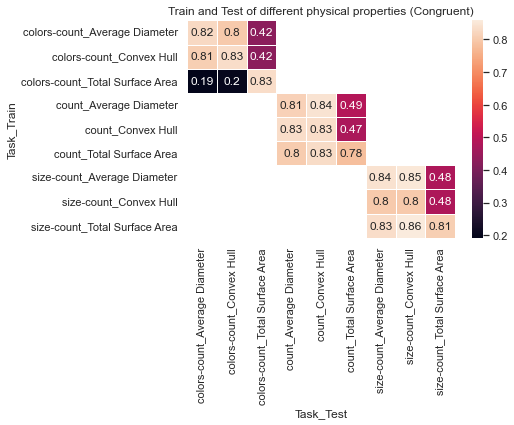

In [124]:
df_for_heatmap = anova_df_for_plots_grouped.query(f"(Task == 'count' or Task =='size-count' or Task == 'colors-count') and (Congruency == 1)")
df_for_heatmap = pd.pivot_table(df_for_heatmap, values='Validation Accuracy', index='Task_Train', columns='Task_Test')
sns.heatmap(df_for_heatmap, annot=True, linewidths=.5).set(title=f"Train and Test of different physical properties (Congruent)")

[Text(0.5, 1.0, 'Train and Test of different physical properties (Inongruent)')]

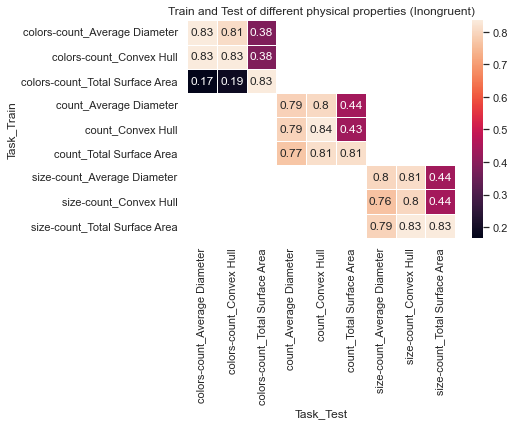

In [123]:
df_for_heatmap = anova_df_for_plots_grouped.query(f"(Task == 'count' or Task =='size-count' or Task == 'colors-count') and (Congruency == 0)")
df_for_heatmap = pd.pivot_table(df_for_heatmap, values='Validation Accuracy', index='Task_Train', columns='Task_Test')
sns.heatmap(df_for_heatmap, annot=True, linewidths=.5).set(title=f"Train and Test of different physical properties (Inongruent)")

In [126]:
df_for_heatmap = anova_df_for_plots_grouped.query(f"(Task == 'size' or Task =='count-size') and (Congruency == 1)")
df_for_heatmap = pd.pivot_table(df_for_heatmap, values='Validation Accuracy', index='Task_Train', columns='Task_Test')
sns.heatmap(df_for_heatmap, annot=True, linewidths=.5).set(title=f"Size Perception tasks: Train and Test of different physical properties (Congruent)")

ValueError: zero-size array to reduction operation fmin which has no identity

|Prepare ANOVA file for R

In [61]:
import pingouin as pg
from dfply import *
anova_results = pg.mixed_anova(dv='Validation Accuracy', between=['Task', 'Train'], within=['Test', 'Congruency', 'Ratio'], subject='UNIQUE_SUBJECT_UID', data=anova_df)

ValueError: within and between factors must both be strings referring to a column in the data. Specifying multiple within and between factors is currently not supported. For more information, see: https://github.com/raphaelvallat/pingouin/issues/136

In [ ]:
model = ols("""Val_Accuracy ~ C(program) + C(gender) + C(division) +
               C(program):C(gender) + C(program):C(division) + C(gender):C(division) +
               C(program):C(gender):C(division)""", data=df).fit()

sm.stats.anova_lm(model, typ=2)